In [1]:
import pyemma
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import numpy as np
from glob import glob

In [2]:
pdb_file = "/Volumes/DATA/MSM_Zuckerman/chignolin/chig_pdb_166.pdb"

In [3]:
traj_files = sorted(glob("/Volumes/DATA/MSM_Zuckerman/chignolin/*.dcd"))

In [4]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)
X = source.get_output()

20-06-18 21:11:00 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


<ipython-input-4-9a1506e8de43>:3: PyEMMA_DeprecationWarning: Passed deprecated argument "chunk_size", please use "chunksize"
  source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)


HBox(children=(HBox(children=(Label(value='getting output of FragmentedTrajectoryReader'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=54), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [5]:
# top model is commute, tica lag 5 frames, 21 tics, 200 microstates, msm lag 500 frames

In [6]:
tica = pyemma.coordinates.tica(X, lag=5, dim=21, kinetic_map=False, commute_map=True)

In [7]:
tica.ndim

21

In [8]:
(np.cumsum(tica.timescales)/np.sum(tica.timescales))[20]

0.95285156071076627

In [9]:
Y = tica.get_output()

In [13]:
kmeans = pyemma.coordinates.cluster_kmeans(Y, k=200, max_iter=1000)

HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=200), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=1000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

20-06-18 21:49:18 pyemma.coordinates.clustering.kmeans.KmeansClustering[8] INFO     Cluster centers converged after 3 steps.


In [14]:
dtrajs = kmeans.dtrajs

In [17]:
np.save('chignolin_dtrajs_100ns', dtrajs)

In [5]:
dtrajs = list(np.load('chignolin_dtrajs_100ns.npy'))

In [6]:
its = pyemma.msm.its(dtrajs, 2000, errors='bayes')

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

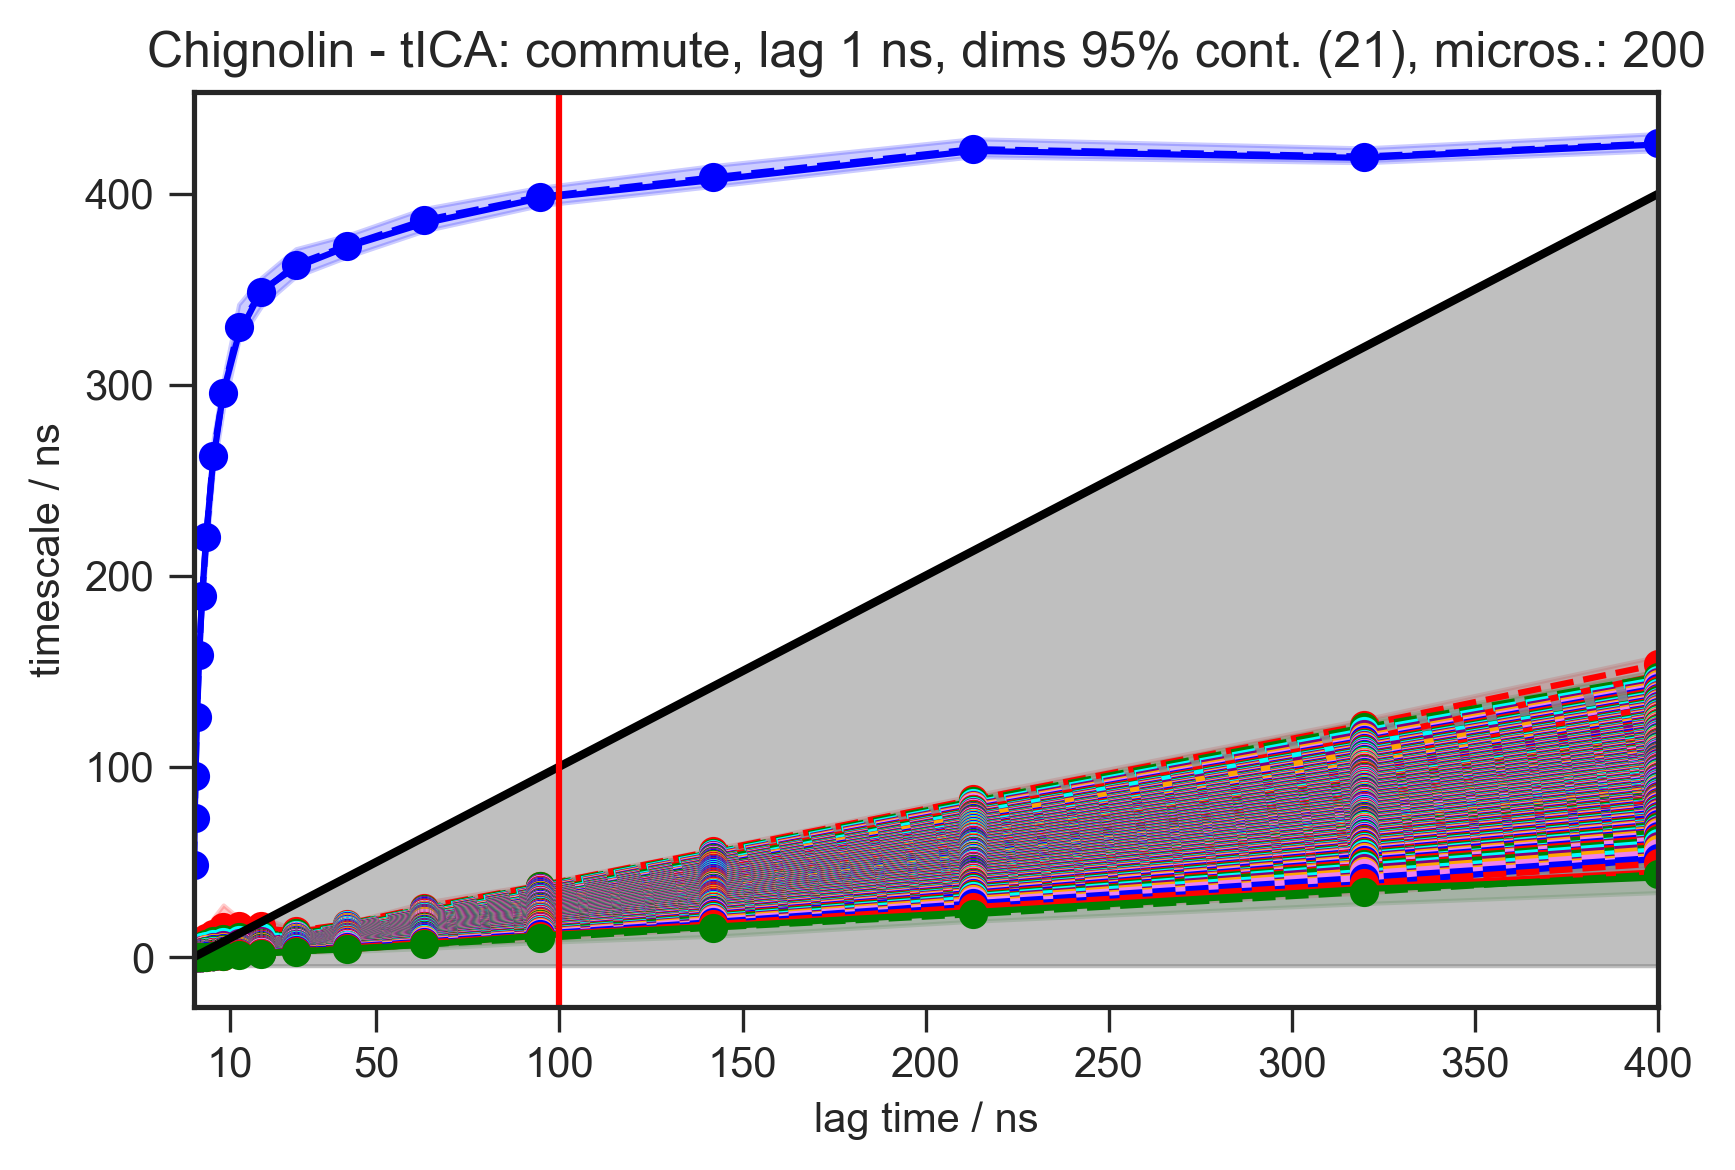

In [19]:
plt.figure(dpi=300)
pyemma.plots.plot_implied_timescales(its, ylog=False, dt=0.2, units='ns')
plt.axvline(100, c='red')
plt.title('Chignolin - tICA: commute, lag 1 ns, dims 95% cont. (21), micros.: 200')
plt.xticks([10,50,100,150,200,250,300,350,400])
plt.tight_layout()
plt.savefig('chignolin_its_100ns.png', dpi=300)
plt.savefig('chignolin_its_100ns.pdf')

In [18]:
# plot 10ns, 50ns, and 100ns lag time timescales together

In [7]:
dtrajs_10ns = list(np.load('../chignolin_dtrajs_lag10ns.npy'))

In [8]:
dtrajs_50ns = list(np.load('../50ns/chignolin_dtrajs_lag50ns.npy'))

In [9]:
its_10ns = pyemma.msm.its(dtrajs_10ns, 2000, errors='bayes')

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [10]:
its_50ns = pyemma.msm.its(dtrajs_50ns, 2000, errors='bayes', n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [11]:
its_100ns = its

In [12]:
import numpy as _np
from pyemma.util.types import  is_iterable_of_int as _is_iterable_of_int, is_int as _is_int

def plot_implied_timescales(ITS, ax=None, outfile=None, show_mle=True, show_mean=True,
                            xlog=False, ylog=True, confidence=0.95, refs=None, nits=-1,
                            process=None, units='steps', dt=1., colors = ['blue'], **kwargs):
    r"""Implied timescale plot
    Parameters
    ----------
    ITS : implied timescales object.
        Object whose data will be plotted. Must provide the functions: get_timescales() and get_timescales(i) where i is the
        the property samples_available
    ax : matplotlib Axes object, optional, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    outfile : str, optional, default = None
        output file to write the figure to. When not given, the plot will be displayed
    show_mean : bool, default = True
        Line for mean value will be shown, if available
    show_mle : bool, default = True
        Line for maximum likelihood estimate will be shown
    xlog : bool, optional, default = False
        Iff true, the x-Axis is logarithmized
    ylog : bool, optional, default = True
        Iff true, the y-Axis is logarithmized
    confidence : float, optional, default = 0.95
        The confidence interval for plotting error bars (if available)
    refs : ndarray((m), dtype=float), optional, default = None
        Reference (exact solution or other reference) timescales if known. The number of timescales must match those
        in the ITS object
    nits: integer, default = -1
        Number of implied timescales to be shown. The default behaviour (-1) is to show all timescales available.
        :py:obj:`nits` != -1 and :py:obj:`process` != None are mutually exclusive
    process : iterable of integers, default is None
        list or ndarray((m), dtype=int) containing a list of the processes to be shown. The default behaviour is
        to show all timescales available.
        :py:obj:`process` != None and :py:obj:`nits` != -1 are mutually exclusive
    units: str or list (len=2) of strings, optional, default = 'steps'
        Affects the labeling of the axes. Used with :py:obj:`dt`, allows for changing the physical units of the axes.
        Accepts simple LaTeX math strings, eg. '$\mu$s'
        If this parameter is a list, it will be assumed that units[0] is for the x-axis and units[1] for the y-axis.
    dt: float or list(len=2) of floats, optional, default = 1.0
        Physical time between frames, expressed the units given in :py:obj:`units`. E.g, if you know that each
        frame corresponds to .010 ns, you can use the combination of parameters :py:obj:`dt` =0.01,
        :py:obj:`units` ='ns' to display the implied timescales in ns (instead of frames)
        If this parameter is a list, it will be assumed that dt[0] is for the x-axis and dt[1] for the y-axis.
    **kwargs: Will be passed to pyplot.plot when plotting the MLE datapoints (not the bootstrapped means).
            See the doc of pyplot for more options. Most useful lineproperties like `marker='o'` and/or :markersize=5
    Returns
    -------
    ax : Axes object containing the plot
    """
    import matplotlib.pyplot as _plt
    # check input
    if ax is None:
        ax = _plt.gca()
    #colors = ['blue', 'red', 'green', 'cyan', 'purple', 'orange', 'violet']
    lags = ITS.lagtimes
    xmax = _np.max(lags)
    srt = _np.argsort(lags)
    # Check the processes to be shown
    if process is not None:
        if nits != -1:
            raise TypeError(
                'optional arguments nits and process are mutually exclusive:', nits, process)
        if not _is_iterable_of_int(process):
            raise ValueError('process has to be an iterable of integers')
        if _np.max(process)+1 > ITS.number_of_timescales:
            raise ValueError(
                'requested process %u, whereas ITS only contains %u timescales' % (
                    _np.max(process), ITS.number_of_timescales))
        # Now that it's for sure that nits==-1, process is iter_of_ints, and the requested processes exist in its object:
        its_idx = process
    else:
        if not _is_int(nits):
            raise TypeError('nits is not an integer, ',nits)
        if nits == -1:
            nits = ITS.number_of_timescales
        its_idx = _np.arange(ITS.number_of_timescales)[:nits]
    # Check units and dt for user error.
    if isinstance(units, list) and len(units) != 2:
        raise TypeError("If units is a list, len(units) has to be = 2")
    if isinstance(dt, list) and len(dt) != 2:
        raise TypeError("If dt is a list, len(dt) has to be = 2")
    # Create list of units and dts for different axis
    if isinstance(units, str):
        units = [units] * 2
    if isinstance(dt, (float, int)):
        dt = [dt] * 2
    #ymin = min(_np.min(lags), _np.min(ITS.get_timescales()))
    #ymax = 1.5*_np.min(ITS.get_timescales())
    for i in its_idx:
        # plot estimate
        if show_mle:
            ax.plot(
                lags[srt] * dt[0], ITS.get_timescales(process=i)[srt] * dt[1],
                color=colors[i % len(colors)], **kwargs)
        # sample available?
        if ITS.samples_available:# and ITS.sample_number_of_timescales > i):
            # plot sample mean
            if show_mean:
                ax.plot(
                    lags[srt] * dt[0], ITS.get_sample_mean(process=i)[srt] * dt[1], marker='o',
                    color=colors[i % len(colors)], linestyle='dashed')
            (lconf, rconf) = ITS.get_sample_conf(confidence, i)
            ax.fill_between(
                lags[srt] * dt[0], lconf[srt] * dt[1], rconf[srt] * dt[1],
                alpha=0.2, color=colors[i % len(colors)])
        # reference available?
        if refs is not None:
            tref = refs[i] * dt[1]
            ax.plot([0, min(tref, xmax) * dt[0]], [tref, tref], color='black', linewidth=1)
    # cutoff
    ax.plot(lags[srt] * dt[0], lags[srt] * dt[1], linewidth=2, color='black')
    ax.set_xlim([1.0 * dt[0], xmax * dt[0]])
    #ax.set_ylim([ymin,ymax])
    ax.fill_between(
        lags[srt] * dt[0], ax.get_ylim()[0]*_np.ones(len(lags))*dt[1], lags[srt] * dt[1],
        alpha=0.5, color='grey')
    # formatting
    ax.set_xlabel('lag time / %s' % units[0])
    ax.set_ylabel('timescale / %s' % units[1])
    if (xlog):
        ax.set_xscale('log')
    if (ylog):
        ax.set_yscale('log')
    # show or save
    # if outfile is None:
    #    _plt.show()
    if outfile is not None:
        _plt.savefig(outfile)
    return ax

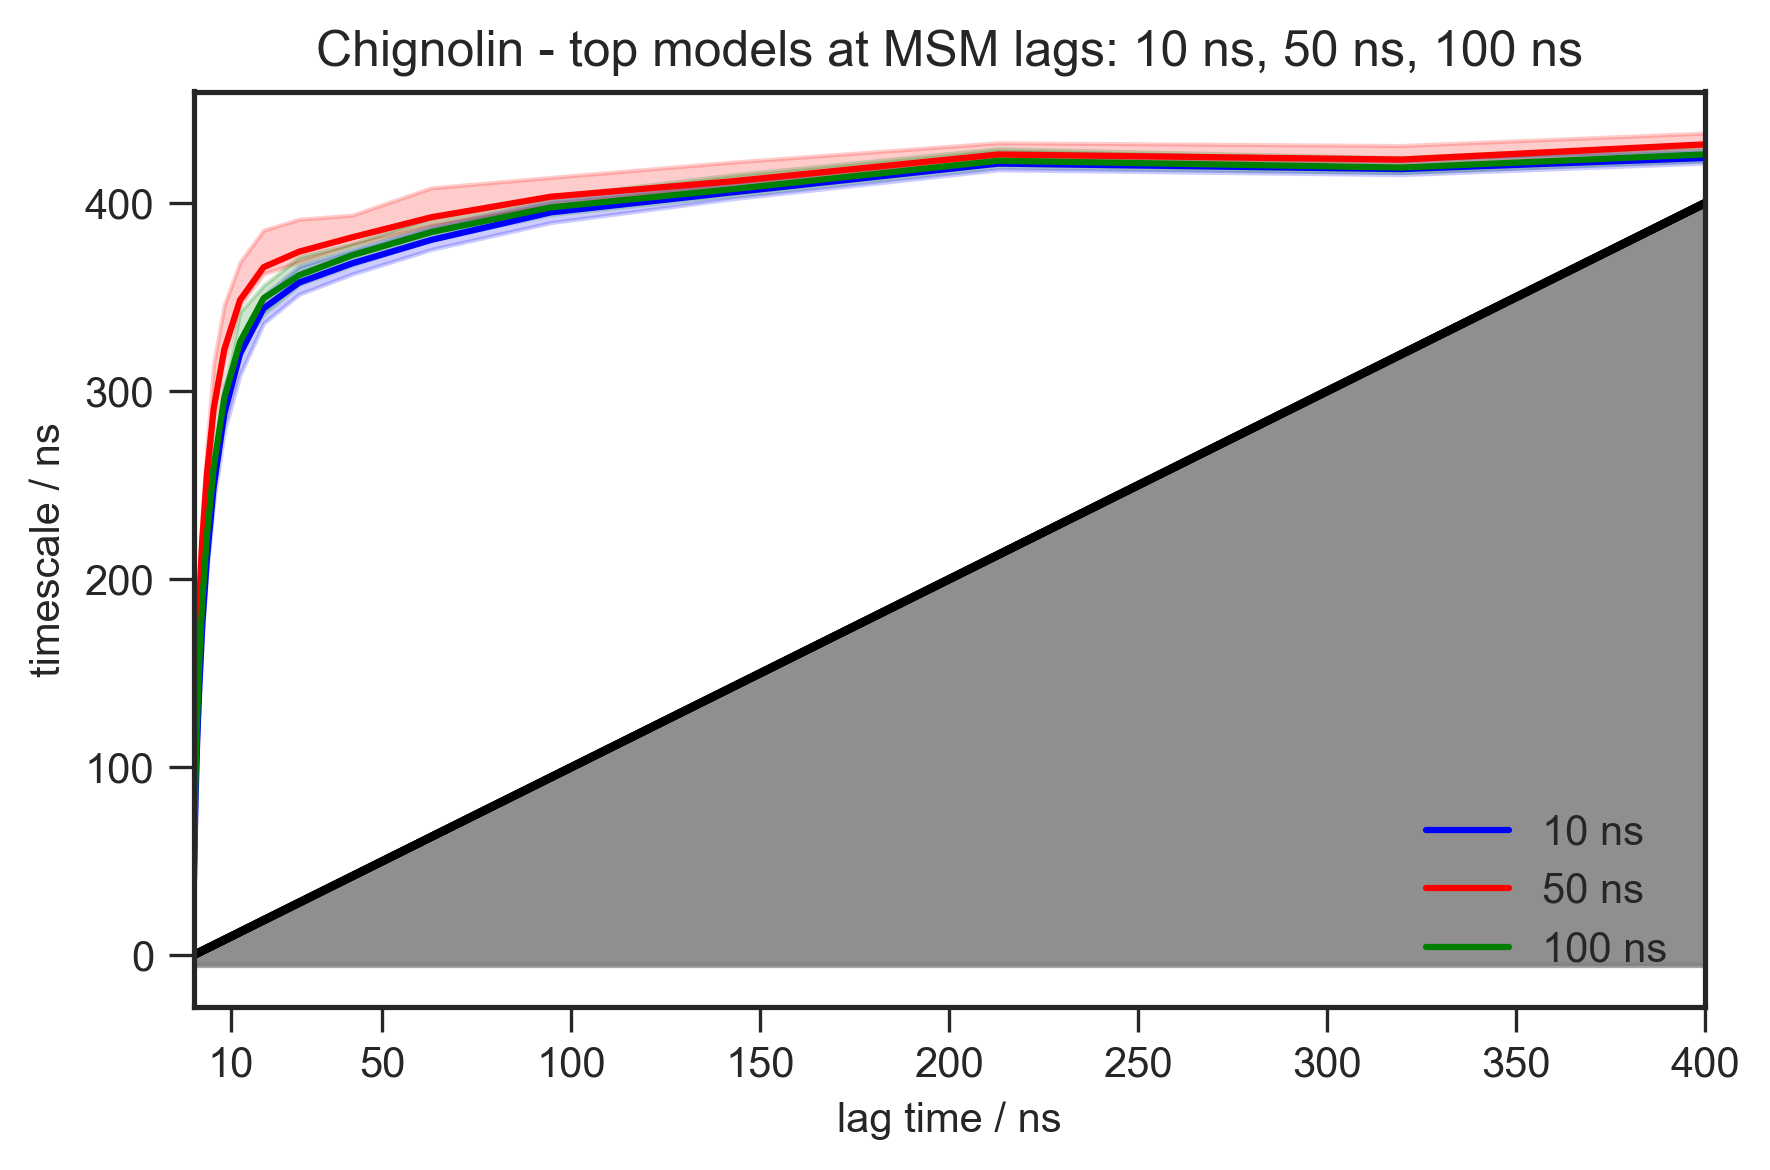

In [15]:
plt.figure(dpi=300)
plot_implied_timescales(its_10ns, ylog=False, dt=0.2, units='ns', nits=1, show_mean=False, label='10 ns')
plot_implied_timescales(its_50ns, ylog=False, dt=0.2, units='ns', nits=1, colors=['red'], show_mean=False, label='50 ns')
plot_implied_timescales(its_100ns, ylog=False, dt=0.2, units='ns', nits=1, colors=['green'], show_mean=False, label='100 ns')
plt.legend()
#plt.axvline(10, c='red')
plt.title('Chignolin - top models at MSM lags: 10 ns, 50 ns, 100 ns')
plt.xticks([10,50,100,150,200,250,300,350,400])
plt.tight_layout()
plt.savefig('chignolin_its_multilag.png', dpi=300)
plt.savefig('chignolin_its_multilag.pdf')

In [16]:
# CK-test

In [17]:
# lag 10 ns

In [18]:
bmsm = pyemma.msm.bayesian_markov_model(dtrajs, 50)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [20]:
ck_test = bmsm.cktest(2, err_est=True, mlags=(np.arange(10) * (200/10)).astype('int'), n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

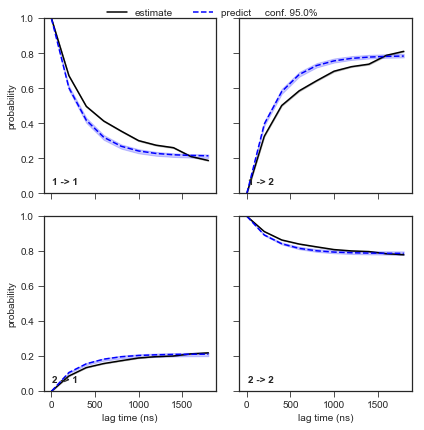

In [21]:
plt.figure()
pyemma.plots.plot_cktest(ck_test, units='ns', dt=0.2)
plt.tight_layout()
plt.savefig('chignolin_cktest_lag10ns_outto1800ns.png', dpi=300)
plt.savefig('chignolin_cktest_lag10ns_outto1800ns.pdf')

In [22]:
# lag 50 ns

In [23]:
bmsm = pyemma.msm.bayesian_markov_model(dtrajs, 250)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [24]:
ck_test = bmsm.cktest(2, err_est=True, mlags=(np.arange(10) * (200/50)).astype('int'), n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

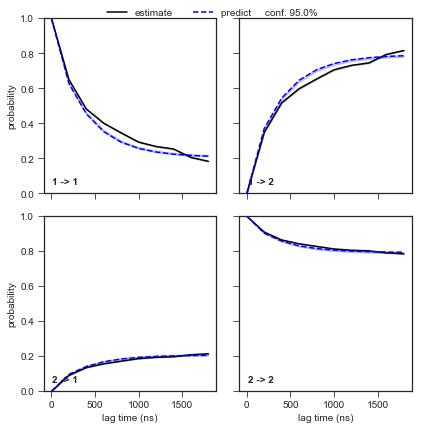

In [25]:
plt.figure()
pyemma.plots.plot_cktest(ck_test, units='ns', dt=0.2)
plt.tight_layout()
plt.savefig('chignolin_cktest_lag50ns_outto1800ns.png', dpi=300)
plt.savefig('chignolin_cktest_lag50ns_outto1800ns.pdf')

In [26]:
# lag 100 ns

In [27]:
bmsm = pyemma.msm.bayesian_markov_model(dtrajs, 500)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [28]:
ck_test = bmsm.cktest(2, err_est=True, mlags=(np.arange(10) * (200/100)).astype('int'), n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

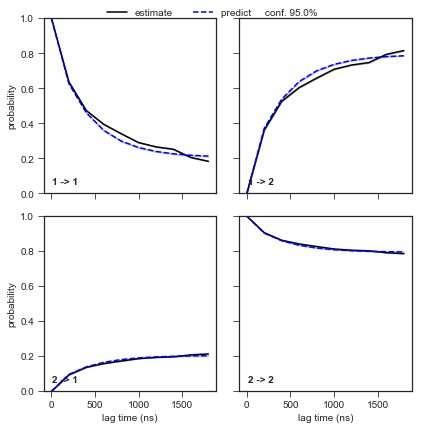

In [29]:
plt.figure()
pyemma.plots.plot_cktest(ck_test, units='ns', dt=0.2)
plt.tight_layout()
plt.savefig('chignolin_cktest_lag100ns_outto1800ns.png', dpi=300)
plt.savefig('chignolin_cktest_lag100ns_outto1800ns.pdf')

In [31]:
# lag 150 ns

In [30]:
bmsm = pyemma.msm.bayesian_markov_model(dtrajs, 750)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [32]:
ck_test = bmsm.cktest(2, err_est=True, mlags=(np.arange(10) * (200/150)).astype('int'), n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

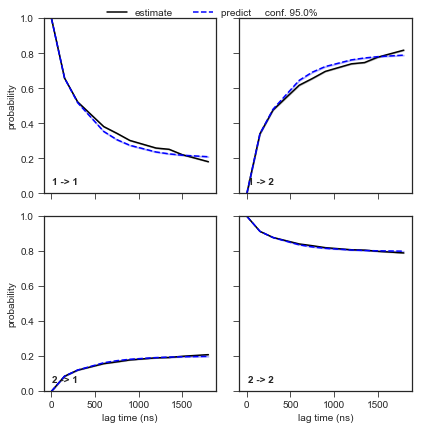

In [33]:
plt.figure()
pyemma.plots.plot_cktest(ck_test, units='ns', dt=0.2)
plt.tight_layout()
plt.savefig('chignolin_cktest_lag150ns_outto1800ns.png', dpi=300)
plt.savefig('chignolin_cktest_lag150ns_outto1800ns.pdf')

In [34]:
# lag 200 ns

In [35]:
bmsm = pyemma.msm.bayesian_markov_model(dtrajs, 1000)

HBox(children=(HBox(children=(Label(value='Sampling MSMs'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [36]:
ck_test = bmsm.cktest(2, err_est=True, mlags=(np.arange(10) * (200/200)).astype('int'), n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=9), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

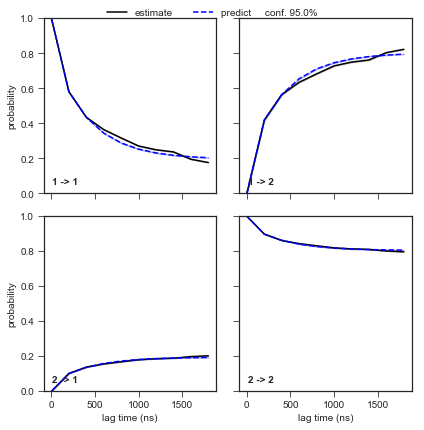

In [37]:
plt.figure()
pyemma.plots.plot_cktest(ck_test, units='ns', dt=0.2)
plt.tight_layout()
plt.savefig('chignolin_cktest_lag200ns_outto1800ns.png', dpi=300)
plt.savefig('chignolin_cktest_lag200ns_outto1800ns.pdf')

In [1]:
# 2 eigenvalue model

In [ ]:
# SAME MODEL

In [38]:
# 10 ns model changed, 50 ns and 100 ns the same - let's plot the 10 - 50 - 100 ITSs again for 2 eigen
# because of the 10 ns model change

In [40]:
dtrajs_10ns = list(np.load('../chignolin_dtrajs_lag10ns_2eigen.npy'))

In [44]:
its_10ns = pyemma.msm.its(dtrajs_10ns, 2000, errors='bayes', n_jobs=8)

HBox(children=(HBox(children=(Label(value='estimating BayesianMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=19), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [41]:
its_50ns = its_50ns

In [42]:
its_100ns = its

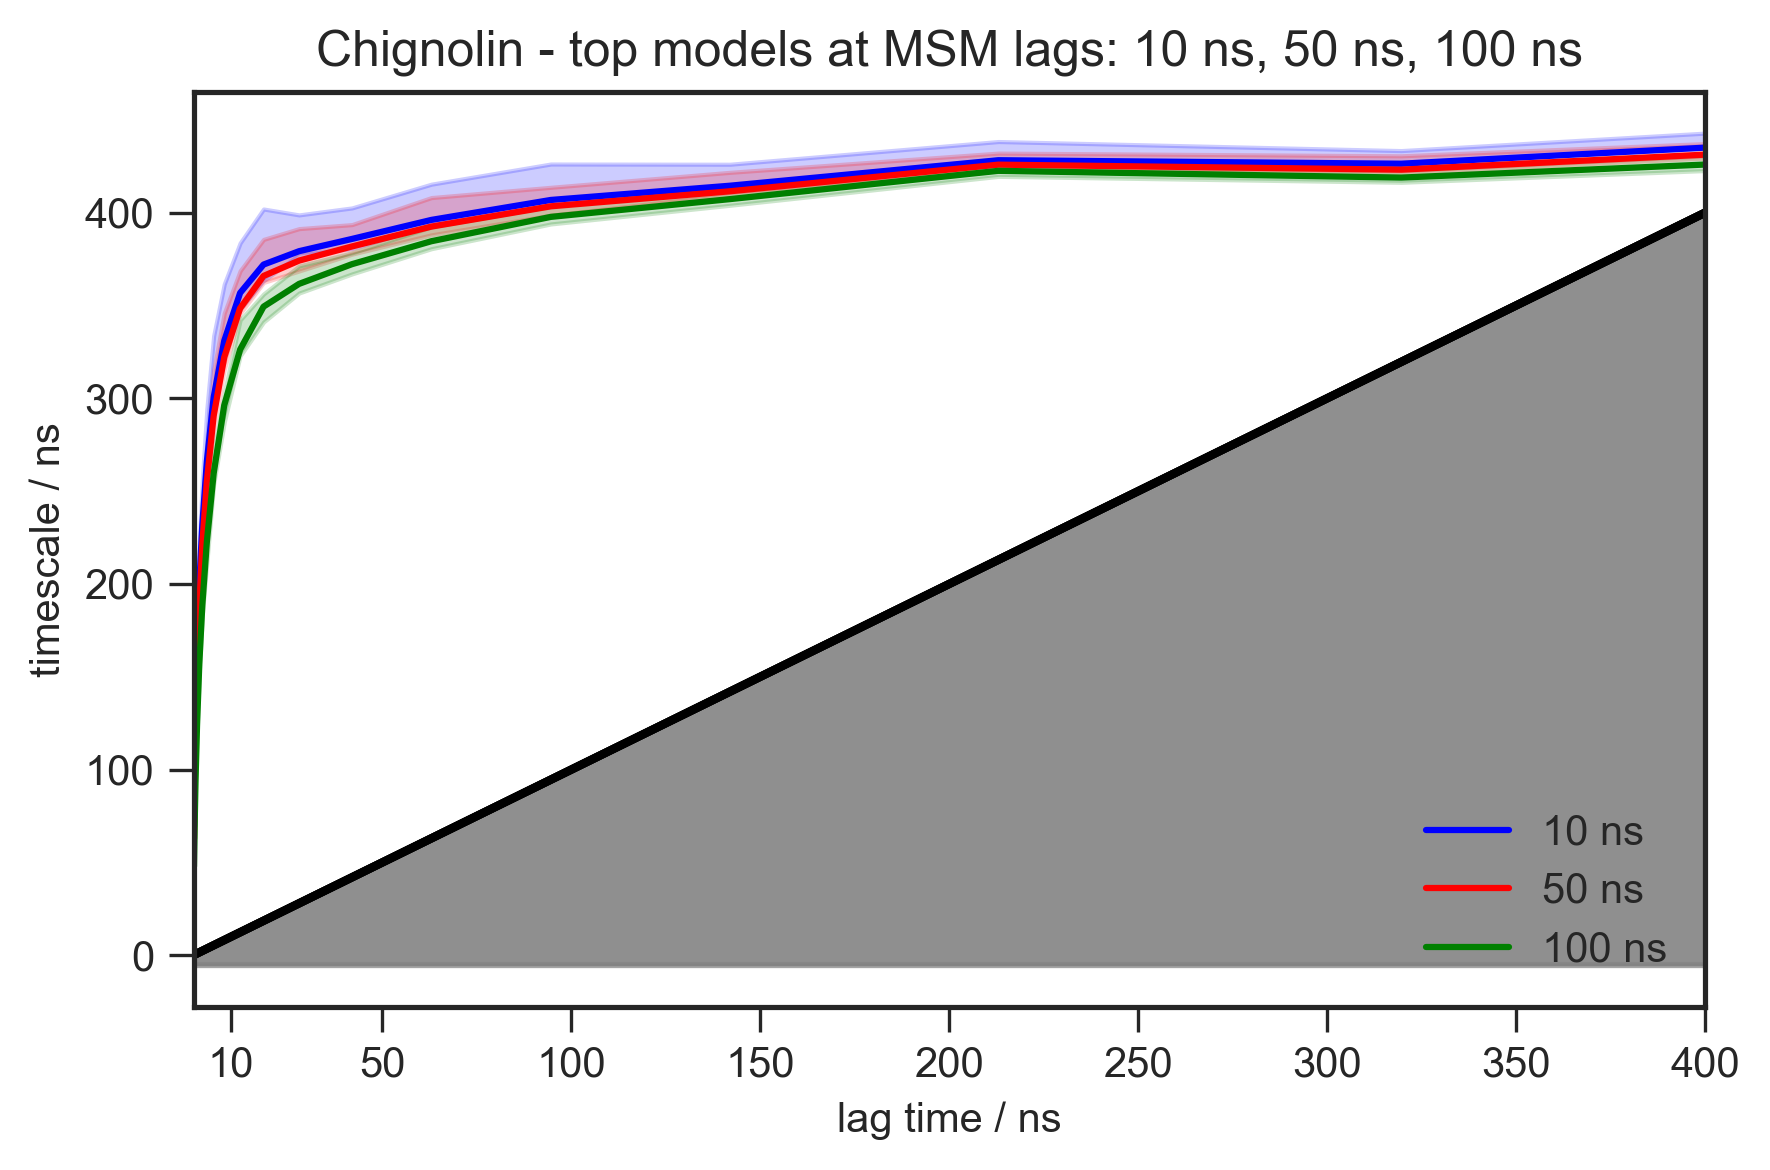

In [45]:
plt.figure(dpi=300)
plot_implied_timescales(its_10ns, ylog=False, dt=0.2, units='ns', nits=1, show_mean=False, label='10 ns')
plot_implied_timescales(its_50ns, ylog=False, dt=0.2, units='ns', nits=1, colors=['red'], show_mean=False, label='50 ns')
plot_implied_timescales(its_100ns, ylog=False, dt=0.2, units='ns', nits=1, colors=['green'], show_mean=False, label='100 ns')
plt.legend()
#plt.axvline(10, c='red')
plt.title('Chignolin - top models at MSM lags: 10 ns, 50 ns, 100 ns')
plt.xticks([10,50,100,150,200,250,300,350,400])
plt.tight_layout()
plt.savefig('chignolin_its_multilag_2eigen.png', dpi=300)
plt.savefig('chignolin_its_multilag_2eigen.pdf')